# Recreating the MIP model but in PuLP

using pulp version 2.7.0

```python -m pip install pulp```

In [1]:
import pulp as plp

import os
import sys
import time

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")

sys.path.append(os.path.join(os.getcwd(), '..','src'))
from optimal_gardening import *

## 1) Define the model and set it as a maximization one

In [3]:
opt_model = plp.LpProblem("MIP_Model", plp.LpMaximize)

## 2) Define variables as dictionaries of LpVariables

In [4]:
x = {(i,j,k): plp.LpVariable(cat=plp.LpBinary, name="x_{0}_{1}_{2}".format(i,j,k)) for i in plant_index for j in bed_index for k in year_index}
y = {(i): plp.LpVariable(cat=plp.LpBinary, name="y_{0}".format(i)) for i in plant_index}

## 3) Define some of the extra things we need

In [ ]:
mip_weights = {'yummy_score': 1, 'variety_score': 0}
sun = sun_constraint[:,:,0]

## 4) Define the objective function

In [5]:
opt_model += (mip_weights['yummy_score']*(plp.lpSum(preferences[p]*plp.lpSum(x[p,b,t] for b in bed_index for t in year_index) for p in plant_index)/max_yums) +
              mip_weights['variety_score']*(plp.lpSum(y[p] for p in plant_index)/num_plants))

## 5) Define Constraints
This was weird but iterating through the generators yielded by each constraint statement and adding each individual constraint to the model seems to do the trick

In [6]:
# One plant per bed constraint
for constraint in (plp.lpSum(x[p,b,t] for p in plant_index) <= 1 for b in bed_index for t in year_index):
    opt_model += constraint

# Sun constraints
for constraint in ((x[p,b,t] <= sun[p,b] for p in plant_index for b in bed_index for t in year_index)):
    opt_model += constraint
    
# Perennial plant constraint
for constraint in (x[p,b,t] >= x[p,b,t-1] for p in plant_index if p in perennials for b in bed_index for t in year_index[1:]):
    opt_model += constraint
    
# Soil-disease if planted in same place over multiple years constraint
for constraint in (x[p,b,t] <= 1 - x[p,b,t-1] for p in plant_index if p in problem_plants for b in bed_index for t in year_index[1:]):
    opt_model += constraint

# Constraint based on relationship between x and y
for constraint in (plp.lpSum(x[p,b,t] for b in bed_index for t in year_index) >= y[p] for p in plant_index):
    opt_model += constraint

## 6) Solve

In [7]:
opt_model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/bchan/miniconda3/envs/optimization/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/707c582e057242bfae26797bbfe5a32d-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/707c582e057242bfae26797bbfe5a32d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5543 COLUMNS
At line 34548 RHS
At line 40087 BOUNDS
At line 44660 ENDATA
Problem MODEL has 5538 rows, 4572 columns and 15324 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0.866667 - 0.01 seconds
Cgl0002I 3024 variables fixed
Cgl0008I 126 inequality constraints converted to equality constraints
Cgl0003I 0 fixed, 0 tightened bounds, 28 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 28 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 28 strengthened rows, 

1

## 7) Solution Analysis

In [32]:
mip_obs = round(plp.value(opt_model.objective)*100,2)
mip_yums = compute_yummy_score(mip_plan,preferences,max_yums)
mip_variety = compute_variety_score(mip_plan,num_plants)

print(f'Overall MIP Objective: {mip_obs}')
print(f'MIP Yummy Score: {mip_yums}')
print(f'MIP Variety Score: {mip_variety}')

Overall MIP Objective: 86.67
MIP Yummy Score: 86.7
MIP Variety Score: 8.3


#### Extract the solution and format in the same way as other example

In [23]:
mip_plan = np.zeros(shape=(num_plants,num_beds,num_years))

for v in opt_model.variables():
    pbt = v.name.split('_')
    if pbt[0] == 'x': #only care about the values of x not y
        p = int(pbt[1])
        b = int(pbt[2])
        t = int(pbt[3])

        if v.varValue == 1:
            mip_plan[p,b,t] = 1

#### Visualize the solution

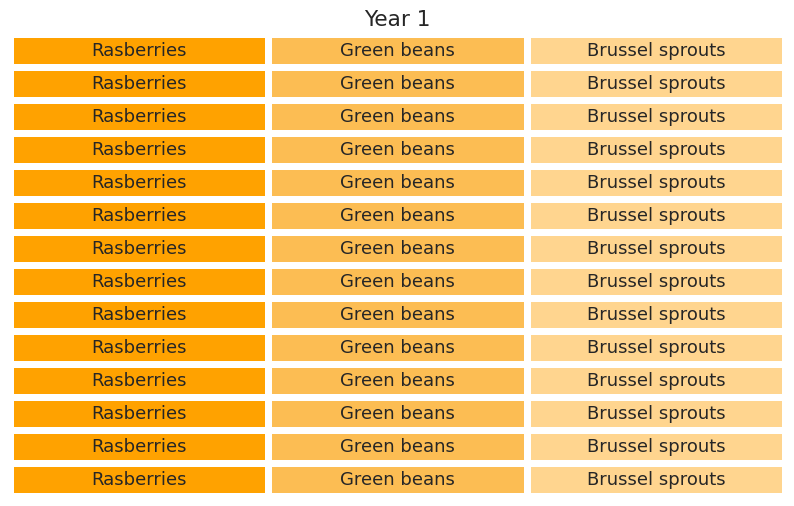

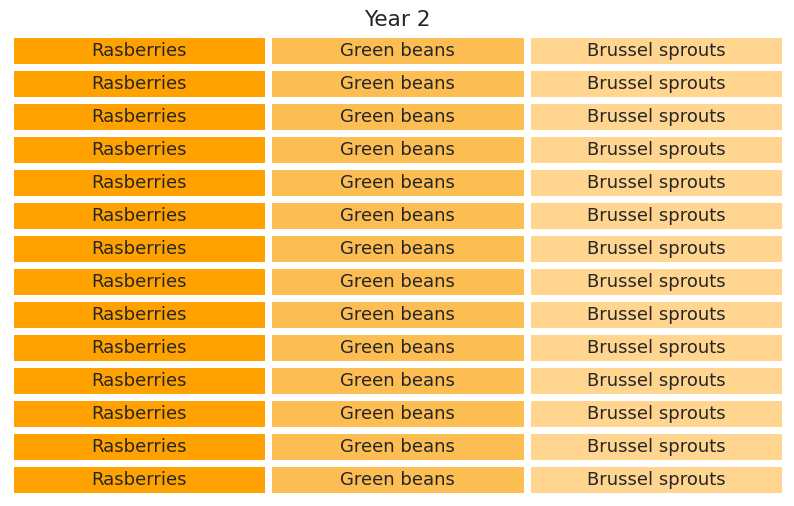

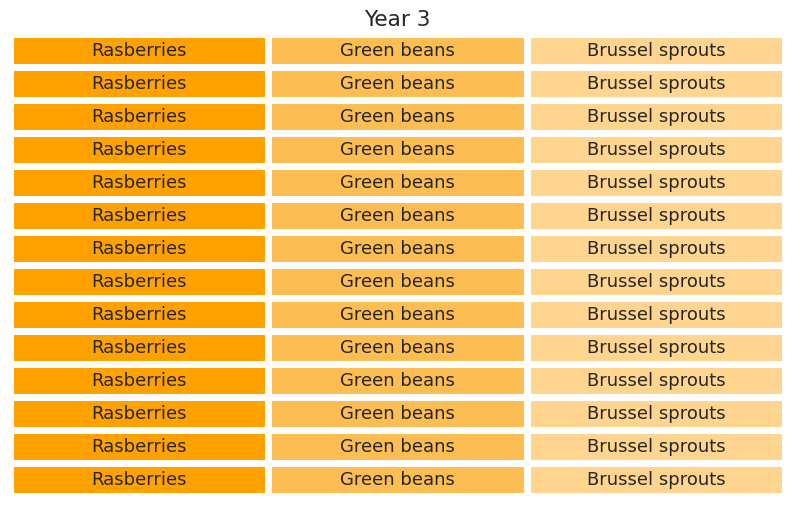

In [25]:
df_mip_plan = annual_bed_plan(mip_plan,bed_info,plant_info,bed_index,year_index)
visualize_plan(df_mip_plan,bed_index,years)